# **Fake News Detection (CNN-LSTM Hybrid Model)**

#### **Authors: *Anirudh B. (2024)* & *Kartik P. (2024)***

We have developed a Automated fake news detection model using a hybrid neural network architecture that integrates Convolutional Neural Networks (CNN) and Long Short-Term Memory (LSTM) networks.

This model leverages a Hybrid approach, to enhance the classification performance by reducing the complexity of feature vectors before passing them through the neural network.

## 1. Import Modules

#### Run this for installing the required modules

In [1]:
# %pip install -r requirements.txt

#### To use GPU even if Display is using Nvidia GPU instead of Intel GPU

In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0" # Removes CUDA errors as GPU might be in use by another process

#### Downloading NLTK Data

In [3]:
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk import word_tokenize 

current_dir = os.getcwd()
nltk_data_dir = os.path.join(current_dir, 'nltk_data')

if not os.path.exists(nltk_data_dir):
    os.makedirs(nltk_data_dir)

nltk.data.path = [nltk_data_dir]
os.environ['NLTK_DATA'] = nltk_data_dir    

try:
    print(f"NLTK data path: {nltk.data.path}")
    stop_words = nltk.corpus.stopwords.words('english')
    wordnet = nltk.corpus.wordnet
    nltk.word_tokenize('sample text')
    print("NLTK data is already available.")
except LookupError:
    print("Downloading NLTK data...")
    nltk.download('stopwords', download_dir=nltk_data_dir)
    nltk.download('wordnet', download_dir=nltk_data_dir)
    nltk.download('punkt', download_dir=nltk_data_dir)
    nltk.download('punkt_tab', download_dir=nltk_data_dir)
    print("NLTK data downloaded successfully.")

stop_words = nltk.corpus.stopwords.words('english')
lemmatizer = nltk.WordNetLemmatizer()

NLTK data path: ['/home/anirudh/Data/Anirudh/BITS/4-1/DL/FakeNewsDetection/backend/nltk_data']
NLTK data is already available.


In [4]:
import gensim.downloader

loaded_glove_model = gensim.downloader.load("glove-wiki-gigaword-300")
loaded_glove_embeddings = loaded_glove_model.vectors

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader
from torch.optim import Adam

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import precision_recall_curve

import itertools

from wordcloud import WordCloud, STOPWORDS

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm
tqdm.pandas(bar_format='{l_bar}{bar:30}{r_bar}')

In [6]:
from statistics import mean
from datetime import datetime
import re
import json

In [7]:
import warnings
warnings.filterwarnings('ignore')

#### Check if CUDA is Available

In [8]:
print("CUDA available:", torch.cuda.is_available())
print("Current device:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "CPU")

print(torch.version.cuda)
print(torch.backends.cudnn.version())

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

CUDA available: True
Current device: NVIDIA GeForce MX250
12.4
90100


device(type='cuda')

In [9]:
params = {
    'target': 'True',
    'data': 'article',
    'embeddingDim': 300,
    'hiddenDim': 256,
    'learningRate': 0.0025,
    'numEpochs': 10,
    'batchSize': 64
}

target = params['target']
data = params['data']
embeddingDim = params['embeddingDim']
hiddenDim = params['hiddenDim']
learningRate = params['learningRate']
numEpochs = params['numEpochs']
batchSize = params['batchSize']

## 2. Import Data

In [10]:
realData = pd.read_csv('./datasets/True.csv')
fakeData = pd.read_csv('./datasets/Fake.csv')

# Add the 'real or fake' column to label each dataset
realData[target] = 1
fakeData[target] = 0

combinedData = pd.concat([realData, fakeData], ignore_index=True)
combinedData = combinedData.sample(frac=1, random_state=42).reset_index(drop=True)

combinedData.head(5)

,title,text,subject,date,True
0,BREAKING: GOP Chairman Grassley Has Had Enoug...,"Donald Trump s White House is in chaos, and th...",News,"July 21, 2017",0
1,Failed GOP Candidates Remembered In Hilarious...,Now that Donald Trump is the presumptive GOP n...,News,"May 7, 2016",0
2,Mike Pence’s New DC Neighbors Are HILARIOUSLY...,Mike Pence is a huge homophobe. He supports ex...,News,"December 3, 2016",0
3,California AG pledges to defend birth control ...,SAN FRANCISCO (Reuters) - California Attorney ...,politicsNews,"October 6, 2017",1
4,AZ RANCHERS Living On US-Mexico Border Destroy...,Twisted reasoning is all that comes from Pelos...,politics,"Apr 25, 2017",0


## 3. Text Preprocessing

In [11]:
def preprocess(text):
	text = text.lower()
	text = re.sub(r'[^a-zA-Z0-9\s]', '', text)

	words = [word for word in text.split() if word not in stop_words]
	words = [lemmatizer.lemmatize(word) for word in words]

	return ' '.join(words)

from multiprocessing import Pool, cpu_count

def preprocessText(texts):
    with Pool(cpu_count()) as p:
        return list(tqdm(p.imap(preprocess, texts), total=len(texts), desc="Preprocessing", bar_format='{desc}: |{bar:30}| {percentage:3.0f}%'))
    
combinedData['title'] = preprocessText(combinedData['title'])
combinedData['text'] = preprocessText(combinedData['text'])

combinedData.head(5)

Preprocessing: |██████████████████████████████| 100%
Preprocessing: |██████████████████████████████| 100%


,title,text,subject,date,True
0,breaking gop chairman grassley enough demand t...,donald trump white house chaos trying cover ru...,News,"July 21, 2017",0
1,failed gop candidate remembered hilarious mock...,donald trump presumptive gop nominee time reme...,News,"May 7, 2016",0
2,mike pences new dc neighbor hilariously trolli...,mike penny huge homophobe support exgay conver...,News,"December 3, 2016",0
3,california ag pledge defend birth control insu...,san francisco reuters california attorney gene...,politicsNews,"October 6, 2017",1
4,az rancher living usmexico border destroy nanc...,twisted reasoning come pelosi day especially 2...,politics,"Apr 25, 2017",0


# 4. Exploratory Data Preparation & Analysis

#### Remove (Reuters) from text

In [12]:
for i in range(0, len(combinedData["text"])):
    try:
        start = re.search("(Reuters)", combinedData["text"][i][0:49]).end() + 3
    except:
        start = 0
    combinedData.loc[i, "text"] = combinedData.loc[i, "text"][start:]

In [13]:
remaining = combinedData[combinedData['text'].str.contains('Reuters', na=False)]

if remaining.empty:
    print("No occurrences of 'Reuters'")
else:
    print("Found remaining occurrences of 'Reuters':")
    print(remaining)

No occurrences of 'Reuters'


#### Remove Duplicates from Text

In [14]:
combinedData['text'].value_counts()[combinedData['text'].value_counts()>1]

text
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   

In [15]:
combinedData['text'].value_counts()[combinedData['text'].value_counts()>1].sum() - 5262
combinedData = combinedData.drop_duplicates(subset=['text'], ignore_index=True)

#### Checking for Date Length

In [16]:
combinedData['dateLen'] = [len(x) for x in combinedData['date']]
print(combinedData['dateLen'].value_counts())

dateLen
17     7838
12     6689
18     6136
16     3706
14     3631
13     2905
15     2637
11     2472
19     2456
9        35
149       1
66        1
74        1
88        1
120       1
145       1
Name: count, dtype: int64


In [17]:
print(combinedData[combinedData['dateLen']<10]['date'])

1073     15-Feb-18
1800     18-Feb-18
2101     17-Feb-18
2217     16-Feb-18
2253     19-Feb-18
2474     15-Feb-18
8770     19-Feb-18
8961     16-Feb-18
10350    17-Feb-18
14834    15-Feb-18
14843    14-Feb-18
16642    16-Feb-18
18364    16-Feb-18
18723    18-Feb-18
18974    19-Feb-18
20360    18-Feb-18
20609    15-Feb-18
21063    16-Feb-18
21304    16-Feb-18
24604    15-Feb-18
25317    18-Feb-18
25401    16-Feb-18
27300    17-Feb-18
28148    17-Feb-18
28557    16-Feb-18
28988    18-Feb-18
29411    15-Feb-18
29618    17-Feb-18
30101    18-Feb-18
33029    15-Feb-18
33930    17-Feb-18
34553    15-Feb-18
35380    18-Feb-18
35833    15-Feb-18
36248    17-Feb-18
Name: date, dtype: object


In [18]:
print(combinedData[combinedData['dateLen']>18]['date'])
del combinedData['dateLen']

17       September 26, 2017 
68       September 16, 2016 
81       September 10, 2017 
96       September 12, 2017 
98       September 22, 2017 
                ...         
38469    September 24, 2017 
38488    September 25, 2017 
38491    September 27, 2017 
38497    September 18, 2017 
38502    September 19, 2017 
Name: date, Length: 2462, dtype: object


#### Fixing Dates

In [19]:
indexes = []
for x in combinedData["date"]:
    if re.search("http", x):
        ind = np.where(combinedData["date"] == x)
        (indLst,) = ind
        indexes.append(indLst.tolist())
    elif re.search("MSNBC", x):
        ind = np.where(combinedData["date"] == x)
        (indLst,) = ind
        indexes.append(indLst.tolist())

indexes_ = [element for indLst in indexes for element in indLst]
indexes = list(dict.fromkeys(indexes_))


In [20]:
indexes
combinedData = combinedData.drop(index=indexes)

In [21]:
dates = []
for x in combinedData["date"]:
    try:
        date = datetime.strptime(x, "%B %d, %Y")
    except ValueError:
        try:
            date = datetime.strptime(x, "%d-%b-%y")
        except ValueError:
            try:
                date = datetime.strptime(x, "%b %d, %Y")
            except ValueError:
                date = datetime.strptime(x, "%B %d, %Y ")
    dates.append(date)
combinedData["date"] = dates

In [22]:
combinedData['date'].nunique

<bound method IndexOpsMixin.nunique of 0       2017-07-21
1       2016-05-07
2       2016-12-03
3       2017-10-06
4       2017-04-25
           ...    
38506   2017-10-21
38507   2017-01-18
38508   2016-02-27
38509   2017-11-02
38510   2017-11-01
Name: date, Length: 38505, dtype: datetime64[ns]>

#### Subject Analysis

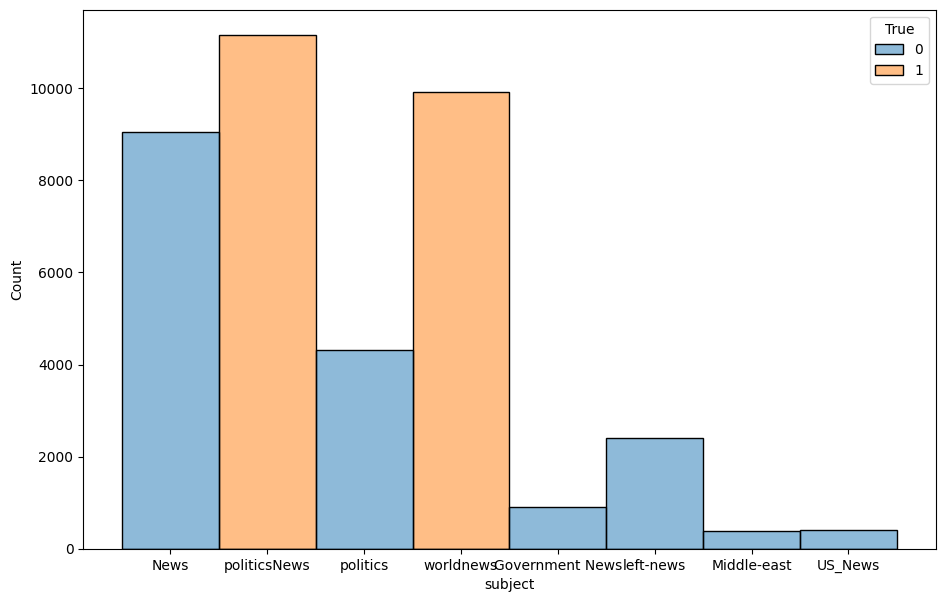

In [23]:
fig, hist = plt.subplots(figsize = (11,7))
hist = sns.histplot(data=combinedData, x = 'subject', hue="True")

In [24]:
combinedData = combinedData.drop(columns=['subject'])
combinedData.head(5)

,title,text,date,True
0,breaking gop chairman grassley enough demand t...,donald trump white house chaos trying cover ru...,2017-07-21,0
1,failed gop candidate remembered hilarious mock...,donald trump presumptive gop nominee time reme...,2016-05-07,0
2,mike pences new dc neighbor hilariously trolli...,mike penny huge homophobe support exgay conver...,2016-12-03,0
3,california ag pledge defend birth control insu...,san francisco reuters california attorney gene...,2017-10-06,1
4,az rancher living usmexico border destroy nanc...,twisted reasoning come pelosi day especially 2...,2017-04-25,0


#### Date Analysis

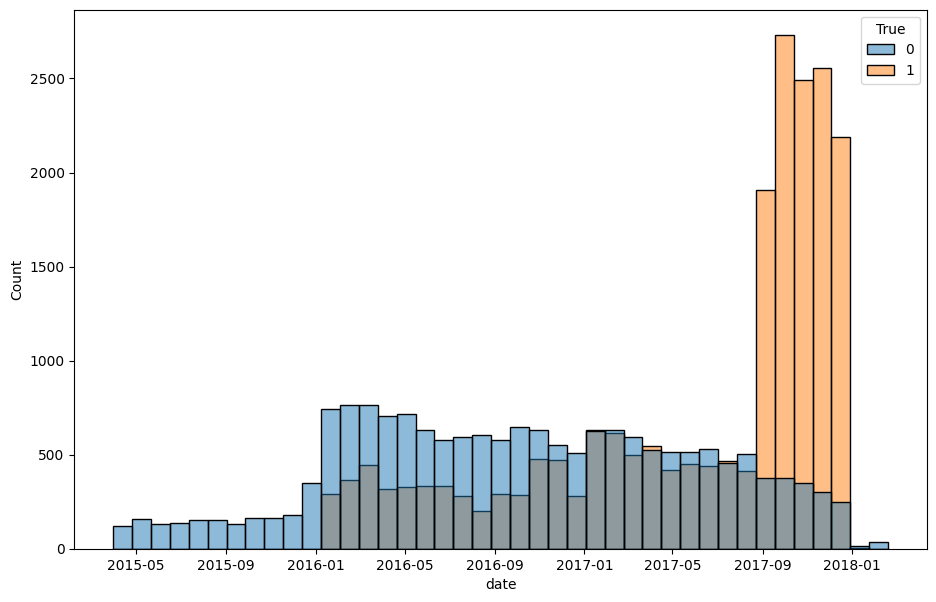

In [25]:
fig, hist = plt.subplots(figsize = (11,7))
hist = sns.histplot(data=combinedData, x = 'date', hue="True")

In [26]:
combinedData = combinedData.drop(columns=['date'])
combinedData.head(5)

,title,text,True
0,breaking gop chairman grassley enough demand t...,donald trump white house chaos trying cover ru...,0
1,failed gop candidate remembered hilarious mock...,donald trump presumptive gop nominee time reme...,0
2,mike pences new dc neighbor hilariously trolli...,mike penny huge homophobe support exgay conver...,0
3,california ag pledge defend birth control insu...,san francisco reuters california attorney gene...,1
4,az rancher living usmexico border destroy nanc...,twisted reasoning come pelosi day especially 2...,0


#### Concatenating Title and Text into one Column

In [27]:
combinedData['article'] = combinedData['title'] + '.' + combinedData['text']
combinedData = combinedData.drop(columns=['title', 'text'])

#### Real Vs Fake

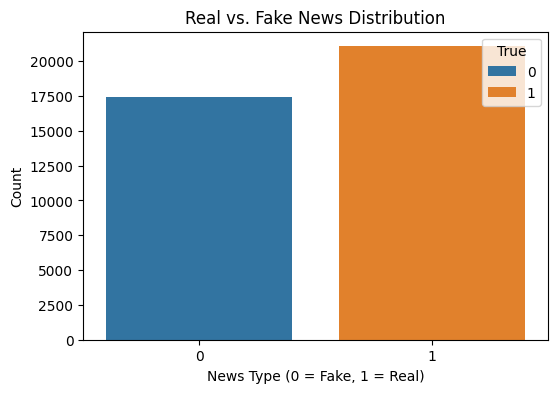

In [28]:
plt.figure(figsize=(6, 4))
sns.countplot(x=target, data=combinedData, hue=target)
plt.title("Real vs. Fake News Distribution")
plt.xlabel("News Type (0 = Fake, 1 = Real)")
plt.ylabel("Count")
plt.show()

#### Text Length Analysis

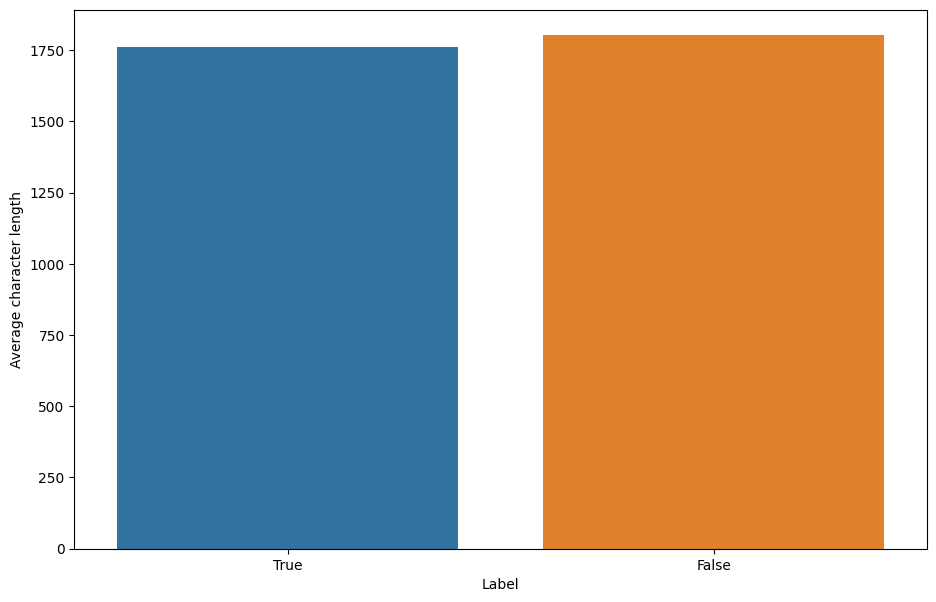

In [29]:
trueLen = combinedData[combinedData[target] == 1][data].apply(lambda x: len(x)).mean()
fakeLen = combinedData[combinedData[target] == 0][data].apply(lambda x: len(x)).mean()
av = pd.DataFrame(data = {'Average character length': [trueLen, fakeLen], 'Label':['True', 'False']})
fig, bar = plt.subplots(figsize = (11,7))
bar = sns.barplot(y='Average character length', x='Label',data=av, hue='Label')

#### Character Length Analysis

Text(0.5, 1.0, 'False texts')

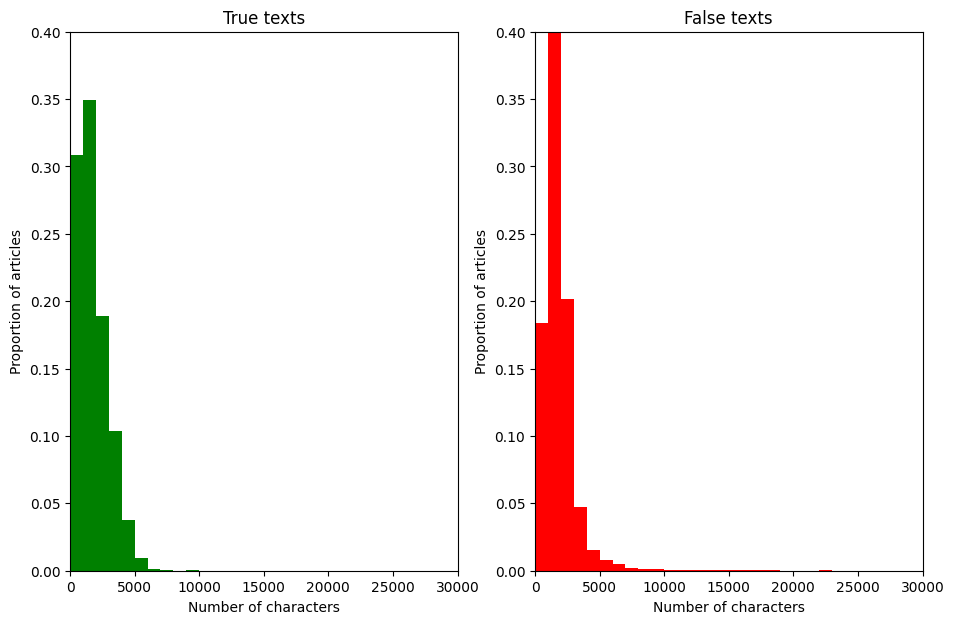

In [30]:
trueCharLen = combinedData[combinedData[target] == 1][data].apply(lambda x: len(x))
falseCharLen = combinedData[combinedData[target] == 0][data].apply(lambda x: len(x))

bins_ = [i * 1000 for i in range(0,31)]

fig, (hist1, hist2) = plt.subplots(1,2, figsize = (11,7))
hist1.hist(trueCharLen, bins = bins_, weights = np.ones(len(trueCharLen))/len(trueCharLen), color = 'g')
hist1.set_ylim(0, top=0.4)
hist1.set_xlim(0, 30000)
hist1.set_xlabel('Number of characters')
hist1.set_ylabel('Proportion of articles')
hist1.set_title('True texts')

hist2.hist(falseCharLen, bins = bins_, weights = np.ones(len(falseCharLen))/len(falseCharLen), color = 'r')
hist2.set_ylim(0, top=0.4)
hist2.set_xlim(0, 30000)
hist2.set_xlabel('Number of characters')
hist2.set_ylabel('Proportion of articles')
hist2.set_title('False texts')

#### Number of words per article

Text(0.5, 1.0, 'False texts')

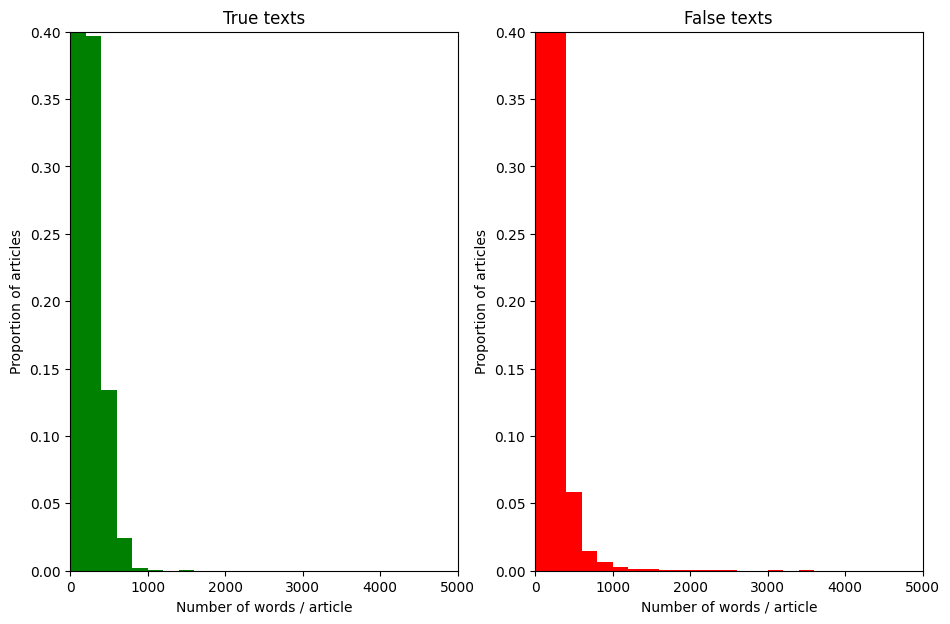

In [31]:
trueWords = combinedData[combinedData[target] == 1][data].str.split().map(lambda x: len(x))
falseWords = combinedData[combinedData[target] == 0][data].str.split().map(lambda x: len(x))

bins_ = [i * 200 for i in range(0,26)]

fig, (hist1, hist2) = plt.subplots(1,2, figsize = (11,7))
hist1.hist(trueWords, bins = bins_, weights = np.ones(len(trueWords))/len(trueWords), color = 'g')
hist1.set_ylim(0, top=0.4)
hist1.set_xlim(0, 5000)
hist1.set_xlabel('Number of words / article')
hist1.set_ylabel('Proportion of articles')
hist1.set_title('True texts')

hist2.hist(falseWords, bins = bins_, weights = np.ones(len(falseWords))/len(falseWords), color = 'r')
hist2.set_ylim(0, top=0.4)
hist2.set_xlim(0, 5000)
hist2.set_xlabel('Number of words / article')
hist2.set_ylabel('Proportion of articles')
hist2.set_title('False texts')

#### Finding common words for Real and Fake Data using Word Cloud

In [32]:
def wordcloud(corpus, title):
    wordcloud = WordCloud(width=1000, height=500, stopwords=STOPWORDS, background_color="white").generate(" ".join(corpus))
    plt.figure(figsize=(15, 8))
    plt.imshow(wordcloud)
    plt.title(title)
    plt.axis("off")
    plt.show()

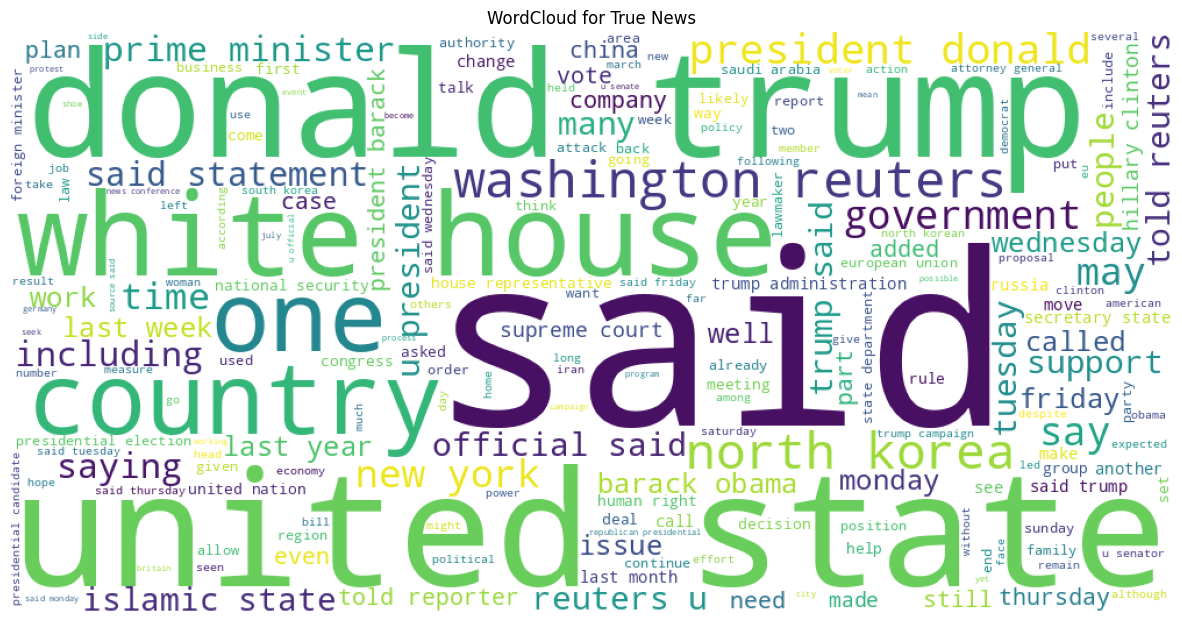

In [33]:
wordcloud(combinedData[combinedData[target]==1][data], "WordCloud for True News")

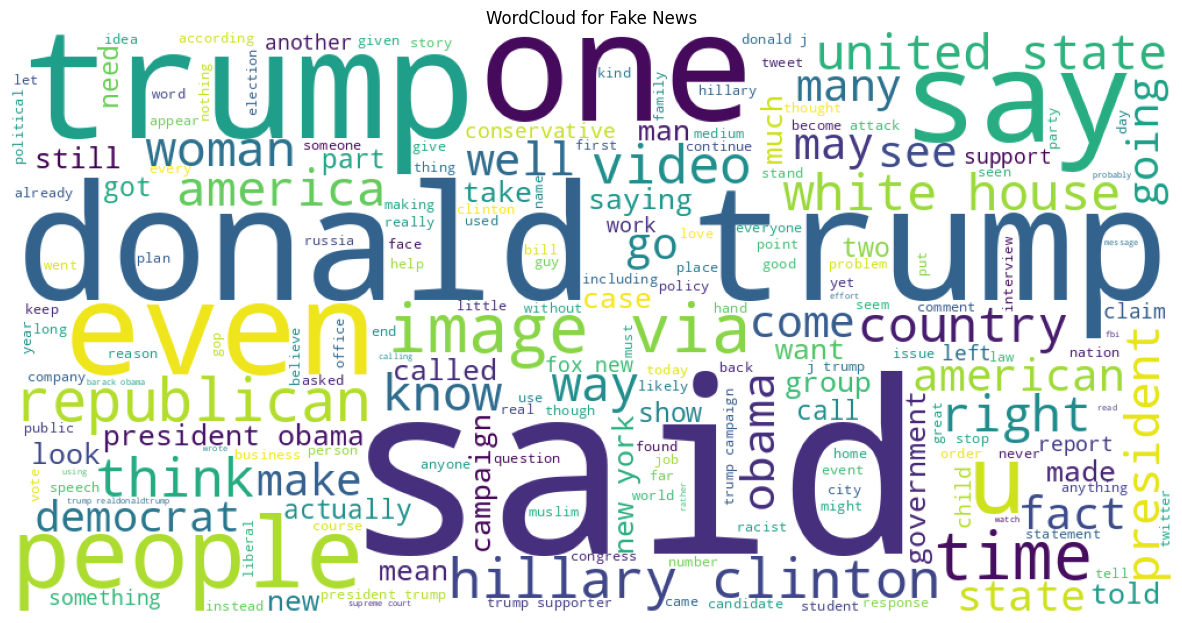

In [34]:
wordcloud(combinedData[combinedData[target]==0][data], "WordCloud for Fake News")

#### N-Grams

In [35]:
def nGrams(corpus, nbGrams, nbWords):
    count = CountVectorizer(ngram_range=(nbGrams, nbGrams)).fit(corpus)
    ensemble = count.transform(corpus).sum(axis=0)
    freq = [(word, ensemble[0, idx]) for word, idx in count.vocabulary_.items()]
    freq = sorted(freq, key = lambda x: x[1], reverse=True)
    return freq[:nbWords]

In [36]:
def plotnGrams(topnGrams, title, n, num_to_show=20):
    df = pd.DataFrame(topnGrams, columns=["ngram", "count"])

    counts, word = df["count"], df["ngram"]
    zippedLists = zip(counts, word)
    sortedPairs = sorted(zippedLists)

    tuples = zip(*sortedPairs)
    counts, word = [list(tuple) for tuple in tuples]

    plt.figure(figsize=[6, 10])
    plt.plot(counts[-num_to_show:], word[-num_to_show:], lw=5, c="b")
    plt.ylabel("{}-grams".format(n), fontsize=20)
    plt.yticks(fontsize=14)
    plt.xlabel("Occurrence count", fontsize=20)
    plt.xticks(fontsize=14)
    plt.title(title, fontsize=20)
    plt.show()

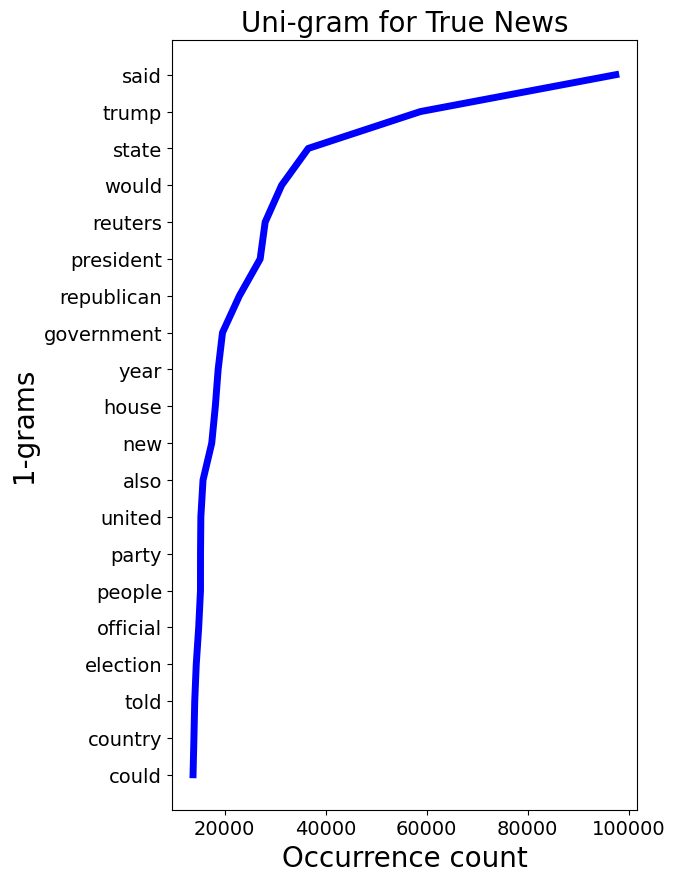

In [37]:
b = nGrams(combinedData[combinedData[target]==1][data],1,20)
plotnGrams(b,"Uni-gram for True News" , 1, num_to_show=20)

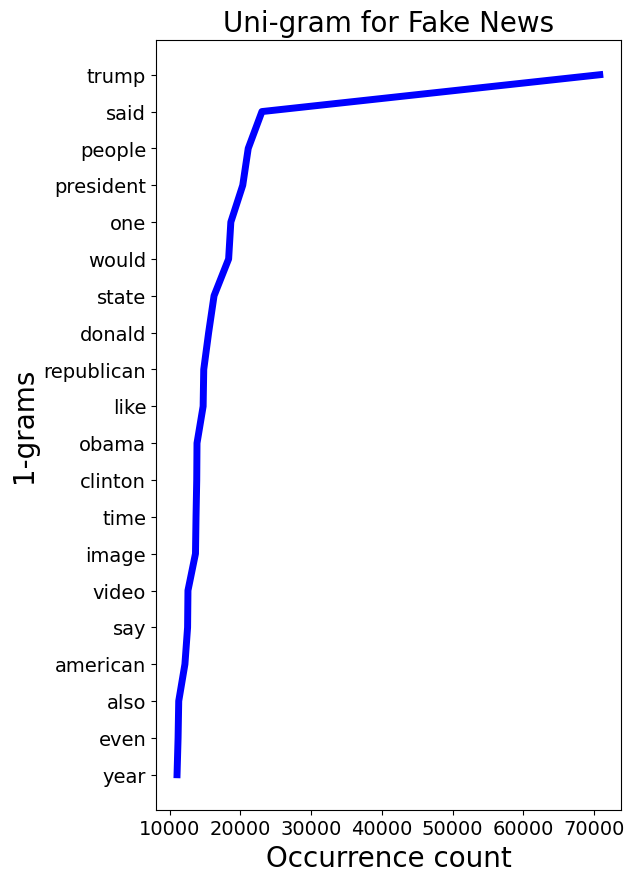

In [38]:
b = nGrams(combinedData[combinedData[target]==0][data],1,20)
plotnGrams(b,"Uni-gram for Fake News", 1, num_to_show=20)

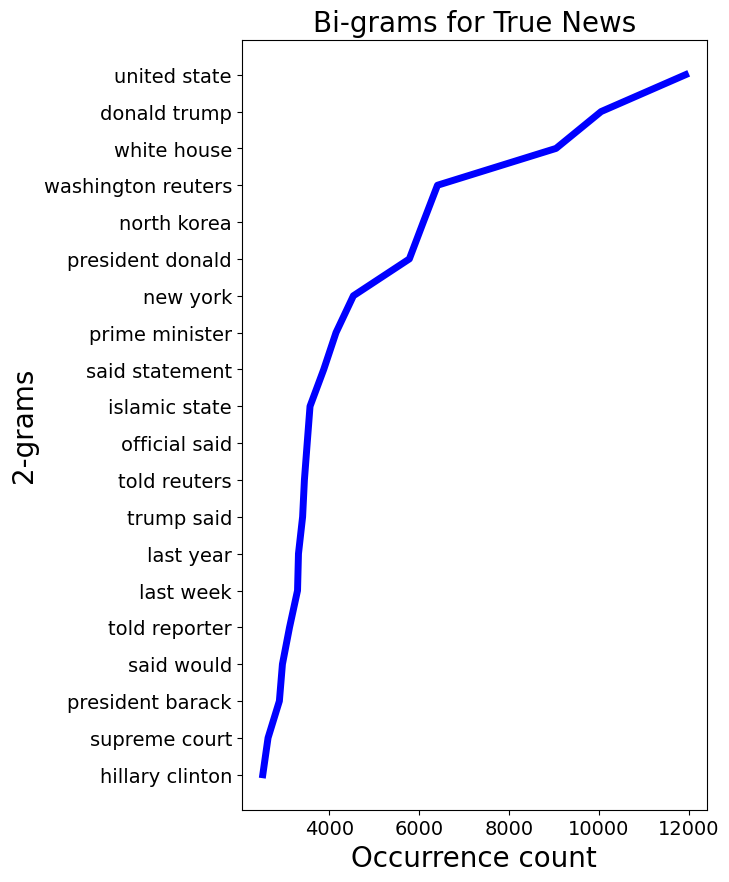

In [39]:
b = nGrams(combinedData[combinedData[target]==1][data],2,20)
plotnGrams(b,"Bi-grams for True News", 2, num_to_show=20)

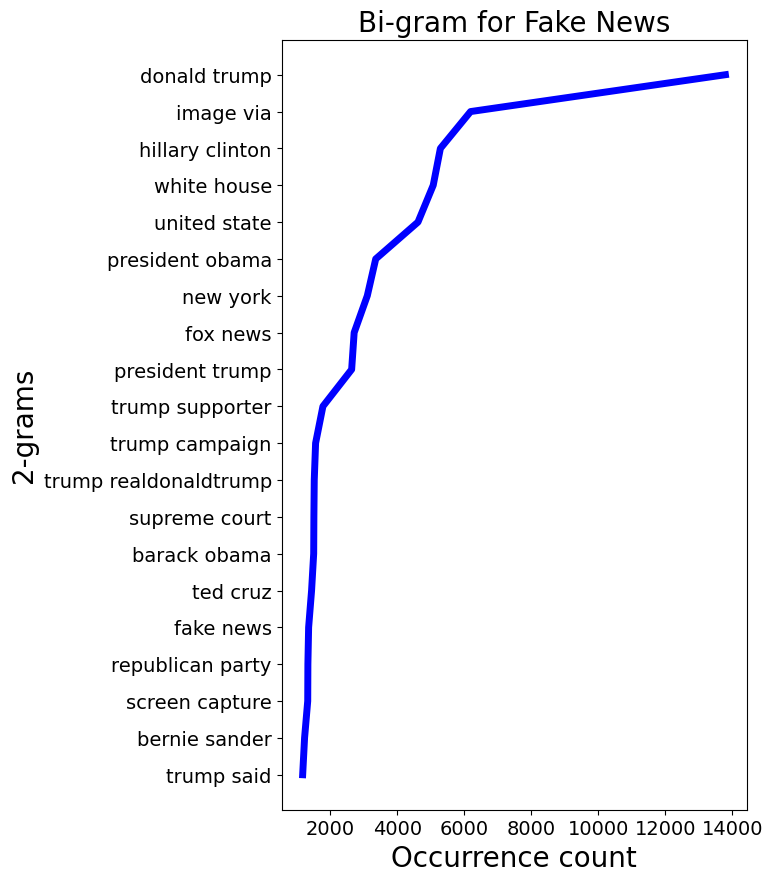

In [40]:
b = nGrams(combinedData[combinedData[target]==0][data],2,20)
plotnGrams(b,"Bi-gram for Fake News", 2, num_to_show=20)

#### Save in CSV

In [41]:
combinedData.to_csv('datasets/combinedData.csv', index=False)

# 5. Splitting Data and Model Params

In [42]:
if 'combinedData' not in globals() and os.path.exists('datasets/combinedData.csv'):	
    combinedData = pd.read_csv('datasets/combinedData.csv')

else:
    os.error('combinedData not available')

combinedData.head(5)

,True,article
0,0,breaking gop chairman grassley enough demand t...
1,0,failed gop candidate remembered hilarious mock...
2,0,mike pences new dc neighbor hilariously trolli...
3,1,california ag pledge defend birth control insu...
4,0,az rancher living usmexico border destroy nanc...


In [43]:
trainData, tempData, trainLabels, tempLabels = train_test_split(
    combinedData, combinedData[target], 
    stratify=combinedData[target], 
    test_size=0.4, 
    random_state=42
)

valData, testData, valLabels, testLabels = train_test_split(
    tempData, tempLabels, 
    stratify=tempLabels, 
    test_size=0.5, 
    random_state=42
)

print(f"Train size: {len(trainData)}, Percentage: {round(len(trainData) / len(combinedData), 2)}")
print(f"Validation size: {len(valData)}, Percentage: {round(len(valData) / len(combinedData), 2)}")
print(f"Test size: {len(testData)}, Percentage: {round(len(testData) / len(combinedData), 2)}")


Train size: 23103, Percentage: 0.6
Validation size: 7701, Percentage: 0.2
Test size: 7701, Percentage: 0.2


In [44]:
x_train = trainData[data]
y_train = trainData[target]

x_val = valData[data]
y_val = valData[target]

x_test = testData[data]
y_test = testData[target]

In [45]:
def distribution(corpus):
    true = corpus.sum()
    false = len(corpus) - true
    distro = pd.DataFrame(
        data={"Number of samples": [true, false], "Label": ["True", "False"]}
    )
    return distro

In [46]:
trainDistro = distribution(trainData[target])
validDistro = distribution(valData[target])
testDistro = distribution(testData[target])

<Axes: xlabel='Label', ylabel='Number of samples'>

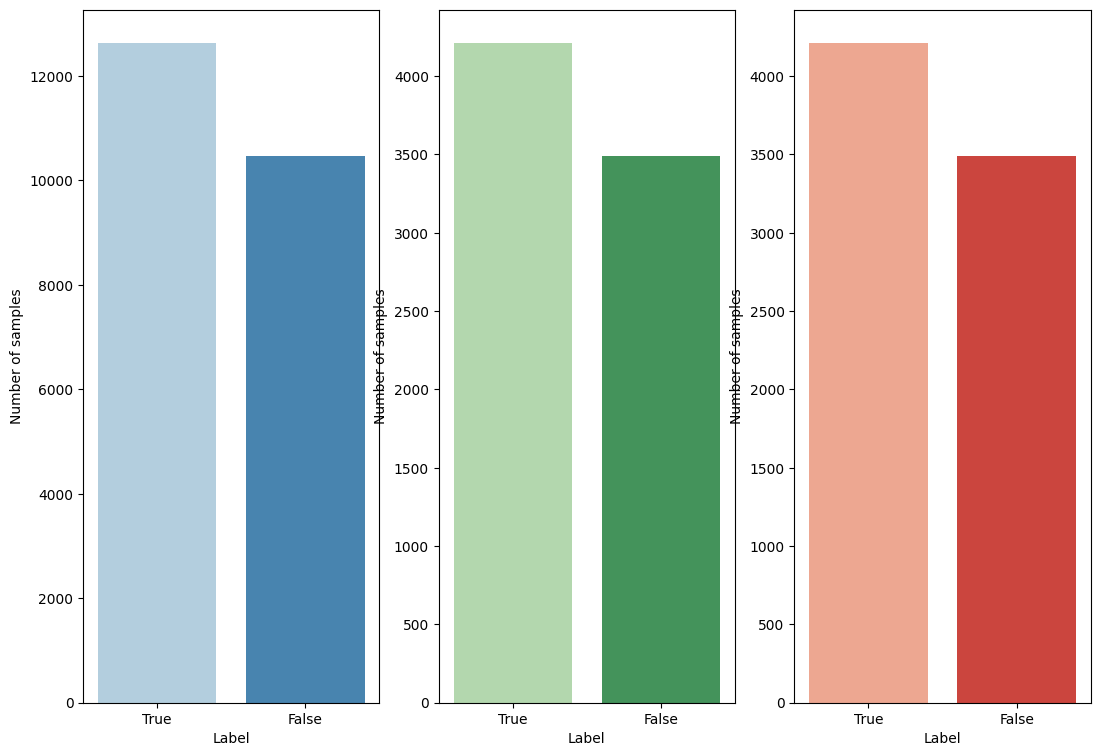

In [47]:
fig, (bar1, bar2, bar3) = plt.subplots(1,3, figsize = (13,9))
sns.barplot(y='Number of samples', x='Label', data=trainDistro, ax=bar1, palette='Blues')
sns.barplot(y='Number of samples', x='Label', data=validDistro, ax=bar2, palette='Greens')
sns.barplot(y='Number of samples', x='Label', data=testDistro, ax=bar3, palette='Reds')

# 6. Tokenization and Padding

In [48]:
def buildVocab(corpus, count_threshold):
    word_counts = {}
    for sent in corpus:
        for word in word_tokenize(sent.lower()):
            if word not in word_counts:
                word_counts[word] = 0
            word_counts[word] += 1
    
    filteredWordCounts = {word: count for word, count in word_counts.items() if count >= count_threshold}
    words = sorted(filteredWordCounts.keys(), key=word_counts.get, reverse=True) + ['UNK']
    word_index = {words[i]: (i + 1) for i in range(len(words))}
    idx_word = {(i + 1): words[i] for i in range(len(words))}
    return word_index, idx_word

In [49]:
def preprocessArticles(data, vocab=None, max_length=100, min_freq=5):
    if vocab is None:
        word2idx, idx2word = buildVocab(data, min_freq)
    else:
        word2idx, idx2word = vocab

    tokenizedData = [word_tokenize(file.lower()) for file in data]
    indexedData = [[word2idx.get(word, word2idx['UNK']) for word in file] for file in tokenizedData]
    tensorData = [torch.LongTensor(file) for file in indexedData]
    truncatedData = [tensor[:max_length] for tensor in tensorData]
    paddedData = pad_sequence(truncatedData, batch_first=True, padding_value=0)
    return paddedData, (word2idx, idx2word)

In [50]:
train_x, train_y = trainData[data], trainData[target]
valid_x, valid_y = valData[data], valData[target]
test_x, test_y = testData[data], testData[target]

trainPadded, (train_word2idx, train_idx2word) = preprocessArticles(train_x)
validPadded, _ = preprocessArticles(valid_x, (train_word2idx, train_idx2word))
testPadded, _ = preprocessArticles(test_x, (train_word2idx, train_idx2word))

In [51]:
trainLabels = torch.FloatTensor(np.array(train_y))
validLabels = torch.FloatTensor(np.array(valid_y))
testLabels = torch.FloatTensor(np.array(test_y))

In [52]:
# Create DataLoaders
def createDL(paddedData, labels, batch_size=32, shuffle=False):
    dataset = list(zip(paddedData, labels))
    return DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)

trainingDL = createDL(trainPadded, trainLabels, batch_size=64, shuffle=True)
validDL = createDL(validPadded, validLabels, batch_size=32)
testDL = createDL(testPadded, testLabels, batch_size=32)

In [53]:
VOCAB_SIZE = len(train_word2idx)

In [54]:
VOCAB_SIZE

33844

In [55]:
# save vocab
with open('vocab.json', 'w') as f:
	json.dump(train_word2idx, f)

In [56]:
trainPadded[1].shape

torch.Size([100])

# 7. Generating Word Embedding using GloVe

In [57]:
def get_glove_adapted_embeddings(glove_model, input_voc):
    # Use key_to_index instead of vocab
    keys = {i: glove_model.key_to_index.get(w, None) for w, i in input_voc.items()}
    index_dict = {i: key for i, key in keys.items() if key is not None}
    embeddings = np.zeros((len(input_voc) + 1, glove_model.vectors.shape[1]))
    for i, ind in index_dict.items():
        embeddings[i] = glove_model[ind]
    return embeddings


GloveEmbeddings = get_glove_adapted_embeddings(loaded_glove_model, train_word2idx)

In [58]:
GloveEmbeddings.shape

(33845, 300)

In [59]:
np.save('glove_embeddings.npy', GloveEmbeddings)

# 8.LSTM

In [60]:
class LSTMModel(nn.Module):
    def __init__(self, embedding_dim, vocabulary_size, hidden_dim, embeddings=None, fine_tuning=False):
        super(LSTMModel, self).__init__()
        
        # Set up embeddings
        if embeddings is not None:
            # Use pre-trained embeddings if provided
            self.embeddings = nn.Embedding.from_pretrained(
                torch.FloatTensor(embeddings),
                freeze=not fine_tuning,  # Allows fine-tuning if required
                padding_idx=0  # Use 0 as the padding index
            )
        else:
            # If no embeddings provided, create a random embedding matrix
            self.embeddings = nn.Embedding(
                num_embeddings=vocabulary_size + 1, 
                embedding_dim=embedding_dim, 
                padding_idx=0
            )

        # LSTM layer: 2 layers as specified
        self.lstm = nn.LSTM(
            input_size=embedding_dim, 
            hidden_size=hidden_dim, 
            batch_first=True, 
            num_layers=2, 
            bidirectional=True  # Adds bidirectional capability
        )

        # Fully connected layer
        self.linear = nn.Linear(
            in_features=2 * hidden_dim,  # Since LSTM is bidirectional, double the hidden_dim
            out_features=1  # Output layer size
        )

    def forward(self, inputs):
        emb = self.embeddings(inputs)
        lstm_out, (ht, ct) = self.lstm(emb)
        h = torch.cat((ht[-2], ht[-1]), dim=1)
        x = self.linear(h)
        return x.view(-1)

In [61]:
def loadCheckpoint(model, optimizer, checkpoint_path):
    checkpoint = torch.load(checkpoint_path)
    model.load_state_dict(checkpoint["model_state_dict"])
    optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
    epoch = checkpoint["epoch"]

    train_losses = checkpoint.get("train_losses", None)
    valid_losses = checkpoint.get("valid_losses", None)
    test_loss = checkpoint.get("test_loss", None)
    train_accs = checkpoint.get("train_accs", None)
    valid_accs = checkpoint.get("valid_accs", None)
    test_acc = checkpoint.get("test_acc", None)
    test_preds = checkpoint.get("test_preds", None)

    print(f"Checkpoint loaded from {checkpoint_path}, epoch {epoch}")

    return (
        model,
        optimizer,
        epoch,
        train_losses,
        valid_losses,
        test_loss,
        train_accs,
        valid_accs,
        test_acc,
        test_preds,
    )

In [62]:
def train_epoch(model, opt, criterion, dataloader, device):
    model.train()
    losses = []
    accs = []
    for i, (x, y) in enumerate(dataloader):
        # Move inputs and targets to the specified device
        x, y = x.to(device), y.to(device)

        opt.zero_grad()
        # Forward pass
        pred = model(x)
        # Loss computation
        y = y.view(-1)
        loss = criterion(pred, y)
        # Backward pass
        loss.backward()
        # Weights update
        opt.step()

        losses.append(loss.item())

        # Compute accuracy
        num_corrects = torch.sum((torch.sigmoid(pred) > 0.5) == y)
        acc = 100.0 * num_corrects / len(y)
        accs.append(acc.item())

        if i % 100 == 0:
            print(
                f"Batch {i}: training loss = {loss.item():.4f}; training acc = {acc.item():.2f}%"
            )

    return losses, accs


def eval_model(model, criterion, evalloader, device):
    model.eval()
    total_epoch_loss = 0
    total_epoch_acc = 0
    preds = []

    with torch.no_grad():
        for i, (x, y) in enumerate(evalloader):
            # Move inputs and targets to the specified device
            x, y = x.to(device), y.to(device)

            y = y.view(-1)

            pred = model(x)
            loss = criterion(pred, y)

            num_corrects = torch.sum((torch.sigmoid(pred) > 0.5) == y)
            acc = 100.0 * num_corrects / len(y)

            total_epoch_loss += loss.item()
            total_epoch_acc += acc.item()
            preds.append(pred)

    return total_epoch_loss / (i + 1), total_epoch_acc / (i + 1), preds


def experiment(
    model,
    opt,
    criterion,
    trainingDL,
    validDL,
    testDL,
    numEpochs=5,
    device=torch.device("cuda"),
):
    model.to(device)
    train_losses = []
    valid_losses = []
    train_accs = []
    valid_accs = []

    print("Beginning training...")
    for e in range(numEpochs):
        print(f"\nEpoch {e + 1}:")
        losses, accs = train_epoch(model, opt, criterion, trainingDL, device)
        train_losses.append(losses)
        train_accs.append(accs)

        valid_loss, valid_acc, val_preds = eval_model(model, criterion, validDL, device)
        valid_losses.append(valid_loss)
        valid_accs.append(valid_acc)

        print(
            f"\nEpoch {e + 1}: Validation loss = {valid_loss:.4f}; Validation acc = {valid_acc:.2f}%"
        )

    test_loss, test_acc, test_preds = eval_model(model, criterion, testDL, device)
    print(f"\nTest loss = {test_loss:.4f}; Test acc = {test_acc:.2f}%")

    return (
        train_losses,
        valid_losses,
        test_loss,
        train_accs,
        valid_accs,
        test_acc,
        test_preds,
    )

In [63]:
model_lstm = LSTMModel(embeddingDim, VOCAB_SIZE, hiddenDim, embeddings=GloveEmbeddings, fine_tuning=False)
optimizer_lstm = Adam(model_lstm.parameters(), lr=learningRate, betas=(0.9, 0.999), weight_decay=0)
criterion = nn.BCEWithLogitsLoss()

In [64]:
torch.cuda.empty_cache()

In [65]:
if not os.path.exists("Model_LSTM_checkpoint.pth"):
    train_losses_lstm, valid_losses_lstm, test_loss_lstm, train_accs_lstm, valid_accs_lstm, test_acc_lstm, test_preds_lstm = experiment(
        model_lstm, optimizer_lstm, criterion, trainingDL, validDL, testDL, numEpochs, device
    )
else:
    model_lstm, optimizer, epoch_lstm, train_losses_lstm, valid_losses_lstm, test_loss_lstm, train_accs_lstm, valid_accs_lstm, test_acc_lstm, test_preds_lstm = loadCheckpoint(
        model_lstm, optimizer_lstm, "Model_LSTM_checkpoint.pth")

Beginning training...

Epoch 1:
Batch 0: training loss = 0.6935; training acc = 42.19%
Batch 100: training loss = 0.0467; training acc = 98.44%
Batch 200: training loss = 0.1179; training acc = 96.88%
Batch 300: training loss = 0.0076; training acc = 100.00%

Epoch 1: Validation loss = 0.0449; Validation acc = 98.43%

Epoch 2:
Batch 0: training loss = 0.0791; training acc = 95.31%
Batch 100: training loss = 0.0231; training acc = 98.44%
Batch 200: training loss = 0.0141; training acc = 98.44%
Batch 300: training loss = 0.0231; training acc = 100.00%

Epoch 2: Validation loss = 0.0397; Validation acc = 98.48%

Epoch 3:
Batch 0: training loss = 0.0077; training acc = 100.00%
Batch 100: training loss = 0.0297; training acc = 98.44%
Batch 200: training loss = 0.0225; training acc = 98.44%
Batch 300: training loss = 0.0032; training acc = 100.00%

Epoch 3: Validation loss = 0.0283; Validation acc = 99.05%

Epoch 4:
Batch 0: training loss = 0.0086; training acc = 100.00%
Batch 100: training 

In [66]:
train_losses = [mean(train_loss) for train_loss in train_losses_lstm]
train_accs = [mean(train_acc) for train_acc in train_accs_lstm]

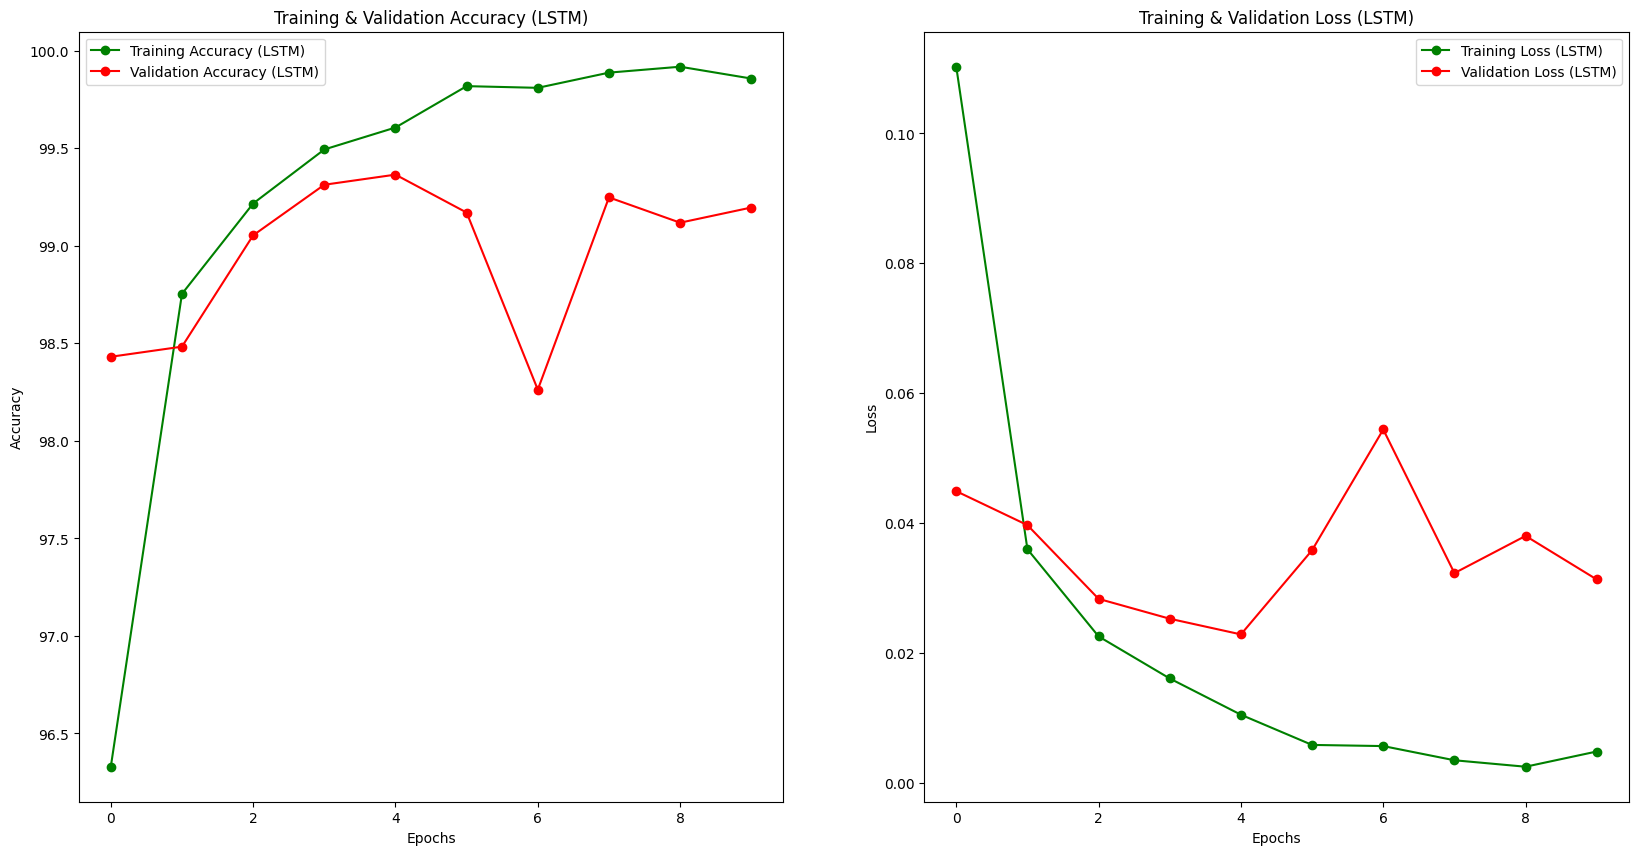

In [67]:
epochs = [i for i in range(numEpochs)]
fig , ax = plt.subplots(1,2)
fig.set_size_inches(20,10)

ax[0].plot(epochs , train_accs , 'go-' , label = 'Training Accuracy (LSTM)')
ax[0].plot(epochs , valid_accs_lstm , 'ro-' , label = 'Validation Accuracy (LSTM)')
ax[0].set_title('Training & Validation Accuracy (LSTM)')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs , train_losses , 'go-' , label = 'Training Loss (LSTM)')
ax[1].plot(epochs , valid_losses_lstm , 'ro-' , label = 'Validation Loss (LSTM)')
ax[1].set_title('Training & Validation Loss (LSTM)')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Loss")
plt.show()

# 9. CNN

In [68]:
class CNNModel(nn.Module):
    def __init__(
        self,
        embedding_dim,
        vocabulary_size,
        window_size: int = 16,
        filter_multiplier = 64,
        embeddings = None,
        fine_tuning = False,
    ):
        super().__init__()
        self.embedding_dim = embedding_dim
        if embeddings:
            self.embeddings = nn.Embedding.from_pretrained(
                torch.FloatTensor(GloveEmbeddings),
                freeze=not fine_tuning,
                padding_idx=0,
            )

        else:
            self.embeddings = nn.Embedding(
                num_embeddings=vocabulary_size + 1,
                embedding_dim=embedding_dim,
                padding_idx=0,
            )

        self.conv1d = nn.Conv1d(embedding_dim, filter_multiplier, window_size)
        self.dropout = nn.Dropout(0.5)
        self.linear = nn.Linear(filter_multiplier, 1)

    def forward(self, inputs):
        x = self.embeddings(inputs)
        x = x.permute(0, 2, 1)
        x = self.conv1d(x)
        x = F.relu(x)
        x = F.max_pool1d(x, x.shape[2]).squeeze(2)
        x = self.dropout(x)
        output = self.linear(x).view(-1)

        return output

In [69]:
model_cnn = CNNModel(embeddingDim, len(train_word2idx), 16, 64, embeddings = True, fine_tuning=True)
optimizer_cnn = Adam(model_cnn.parameters(), lr=learningRate, betas=(0.9, 0.999), weight_decay=0)

In [70]:
if not os.path.exists("Model_CNN_checkpoint.pth"):
	train_losses_cnn, valid_losses_cnn, test_loss_cnn, train_accs_cnn, valid_accs_cnn, test_acc_cnn, test_preds_cnn = experiment(
		model_cnn, 
		optimizer_cnn,
		criterion, 
		trainingDL, 
		validDL, 
		testDL, 
		numEpochs, 
		device
	)
else: model_cnn, optimizer, epoch_cnn, train_losses_cnn, valid_losses_cnn, test_loss_cnn, train_accs_cnn, valid_accs_cnn, test_acc_cnn, test_preds_cnn = loadCheckpoint(
    model_cnn, optimizer_cnn, "Model_CNN_checkpoint.pth")

Beginning training...

Epoch 1:
Batch 0: training loss = 0.7256; training acc = 45.31%
Batch 100: training loss = 0.0136; training acc = 100.00%
Batch 200: training loss = 0.0242; training acc = 100.00%
Batch 300: training loss = 0.0384; training acc = 98.44%

Epoch 1: Validation loss = 0.0323; Validation acc = 99.18%

Epoch 2:
Batch 0: training loss = 0.0071; training acc = 100.00%
Batch 100: training loss = 0.0015; training acc = 100.00%
Batch 200: training loss = 0.0040; training acc = 100.00%
Batch 300: training loss = 0.0047; training acc = 100.00%

Epoch 2: Validation loss = 0.0333; Validation acc = 99.07%

Epoch 3:
Batch 0: training loss = 0.0002; training acc = 100.00%
Batch 100: training loss = 0.0012; training acc = 100.00%
Batch 200: training loss = 0.0007; training acc = 100.00%
Batch 300: training loss = 0.0010; training acc = 100.00%

Epoch 3: Validation loss = 0.0311; Validation acc = 99.22%

Epoch 4:
Batch 0: training loss = 0.0216; training acc = 98.44%
Batch 100: trai

In [71]:
train_losses_cnn = [mean(train_loss) for train_loss in train_losses_cnn]
train_accs_cnn = [mean(train_acc) for train_acc in train_accs_cnn]

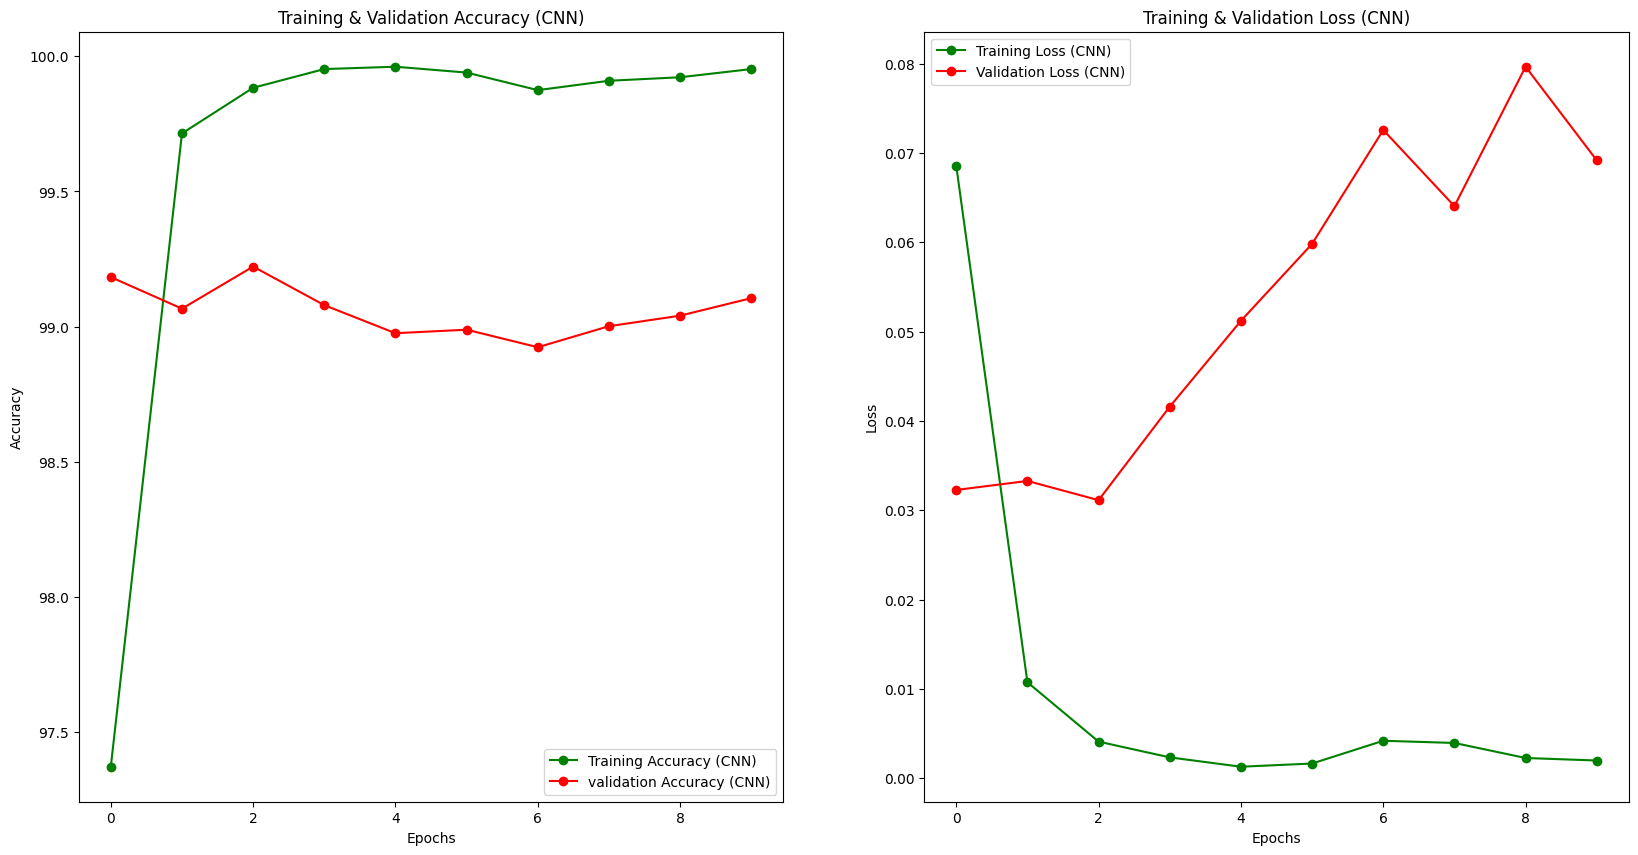

In [72]:
epochs = [i for i in range(numEpochs)]
fig , ax = plt.subplots(1,2)
fig.set_size_inches(20,10)

ax[0].plot(epochs , train_accs_cnn , 'go-' , label = 'Training Accuracy (CNN)')
ax[0].plot(epochs , valid_accs_cnn , 'ro-' , label = 'validation Accuracy (CNN)')
ax[0].set_title('Training & Validation Accuracy (CNN)')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs , train_losses_cnn , 'go-' , label = 'Training Loss (CNN)')
ax[1].plot(epochs , valid_losses_cnn , 'ro-' , label = 'Validation Loss (CNN)')
ax[1].set_title('Training & Validation Loss (CNN)')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Loss")
plt.show()

# 10. CNN-LSTM Hybrid Model

In [73]:
class Hybrid(nn.Module):
    def __init__(
        self, 
        embedding_dim, 
        vocabulary_size, 
        hidden_dim, 
        window_size=16, 
        filter_multiplier=64, 
        embeddings=None, 
        fine_tuning=False
    ):
        super(Hybrid, self).__init__()
        
        # Embedding Layer
        if embeddings is not None:
            self.embeddings = nn.Embedding.from_pretrained(
                torch.FloatTensor(embeddings),
                freeze=not fine_tuning,
                padding_idx=0
            )
        else:
            self.embeddings = nn.Embedding(
                num_embeddings=vocabulary_size + 1,
                embedding_dim=embedding_dim,
                padding_idx=0
            )
        
        # CNN Component
        self.conv1d = nn.Conv1d(embedding_dim, filter_multiplier, window_size)
        self.dropout_cnn = nn.Dropout(0.5)
        
        # LSTM Component
        self.lstm = nn.LSTM(
            input_size=filter_multiplier,
            hidden_size=hidden_dim,
            num_layers=2,
            batch_first=True,
            bidirectional=True
        )
        
        # Fully Connected Layer
        self.fc = nn.Linear(2 * hidden_dim, 1)  # Bidirectional LSTM doubles the hidden dimension

    def forward(self, inputs):
        # Embedding
        x = self.embeddings(inputs)
        
        # CNN Forward Pass
        x = x.permute(0, 2, 1)  # For Conv1d input (batch, channels, sequence_length)
        x = self.conv1d(x)
        x = F.relu(x)
        x = F.max_pool1d(x, x.shape[2]).squeeze(2)  # Global Max Pooling
        x = self.dropout_cnn(x)
        
        # Prepare for LSTM
        x = x.unsqueeze(1).repeat(1, inputs.size(1), 1)  # Repeat CNN features for sequence length
        
        # LSTM Forward Pass
        lstm_out, (ht, ct) = self.lstm(x)
        
        # Concatenate final hidden states from both directions
        h = torch.cat((ht[-2], ht[-1]), dim=1)
        
        # Fully Connected Layer
        output = self.fc(h)
        return output.view(-1)

In [74]:
model_hybrid = Hybrid(embeddingDim, VOCAB_SIZE, hiddenDim, embeddings=GloveEmbeddings, fine_tuning=True)
optimizer_hybrid = Adam(model_hybrid.parameters(), lr=learningRate, betas=(0.9, 0.999), weight_decay=0)

In [75]:
if not os.path.exists("Model_Hybrid_checkpoint.pth"):
	train_losses_hybrid, valid_losses_hybrid, test_loss_hybrid, train_accs_hybrid, valid_accs_hybrid, test_acc_hybrid, test_preds_hybrid = experiment(
		model_hybrid, 
		optimizer_hybrid, 
		criterion, 
		trainingDL, 
		validDL, 
		testDL, 
		numEpochs, 
		device
	)
else: 
	model_hybrid, optimizer_hybrid, epoch_hybrid, train_losses_hybrid, valid_losses_hybrid, test_loss_hybrid, train_accs_hybrid, valid_accs_hybrid, test_acc_hybrid, test_preds_hybrid = loadCheckpoint(
	model_hybrid, optimizer_hybrid, "Model_Hybrid_checkpoint.pth")

Beginning training...

Epoch 1:
Batch 0: training loss = 0.6929; training acc = 50.00%
Batch 100: training loss = 0.1380; training acc = 95.31%
Batch 200: training loss = 0.0499; training acc = 98.44%
Batch 300: training loss = 0.0356; training acc = 98.44%

Epoch 1: Validation loss = 0.0353; Validation acc = 99.04%

Epoch 2:
Batch 0: training loss = 0.0069; training acc = 100.00%
Batch 100: training loss = 0.0019; training acc = 100.00%
Batch 200: training loss = 0.0199; training acc = 98.44%
Batch 300: training loss = 0.0118; training acc = 100.00%

Epoch 2: Validation loss = 0.0344; Validation acc = 99.16%

Epoch 3:
Batch 0: training loss = 0.0138; training acc = 100.00%
Batch 100: training loss = 0.0001; training acc = 100.00%
Batch 200: training loss = 0.0011; training acc = 100.00%
Batch 300: training loss = 0.0003; training acc = 100.00%

Epoch 3: Validation loss = 0.0742; Validation acc = 98.77%

Epoch 4:
Batch 0: training loss = 0.0038; training acc = 100.00%
Batch 100: traini

In [76]:
train_losses_hybrid = [mean(train_loss) for train_loss in train_losses_hybrid]
train_accs_hybrid = [mean(train_acc) for train_acc in train_accs_hybrid]

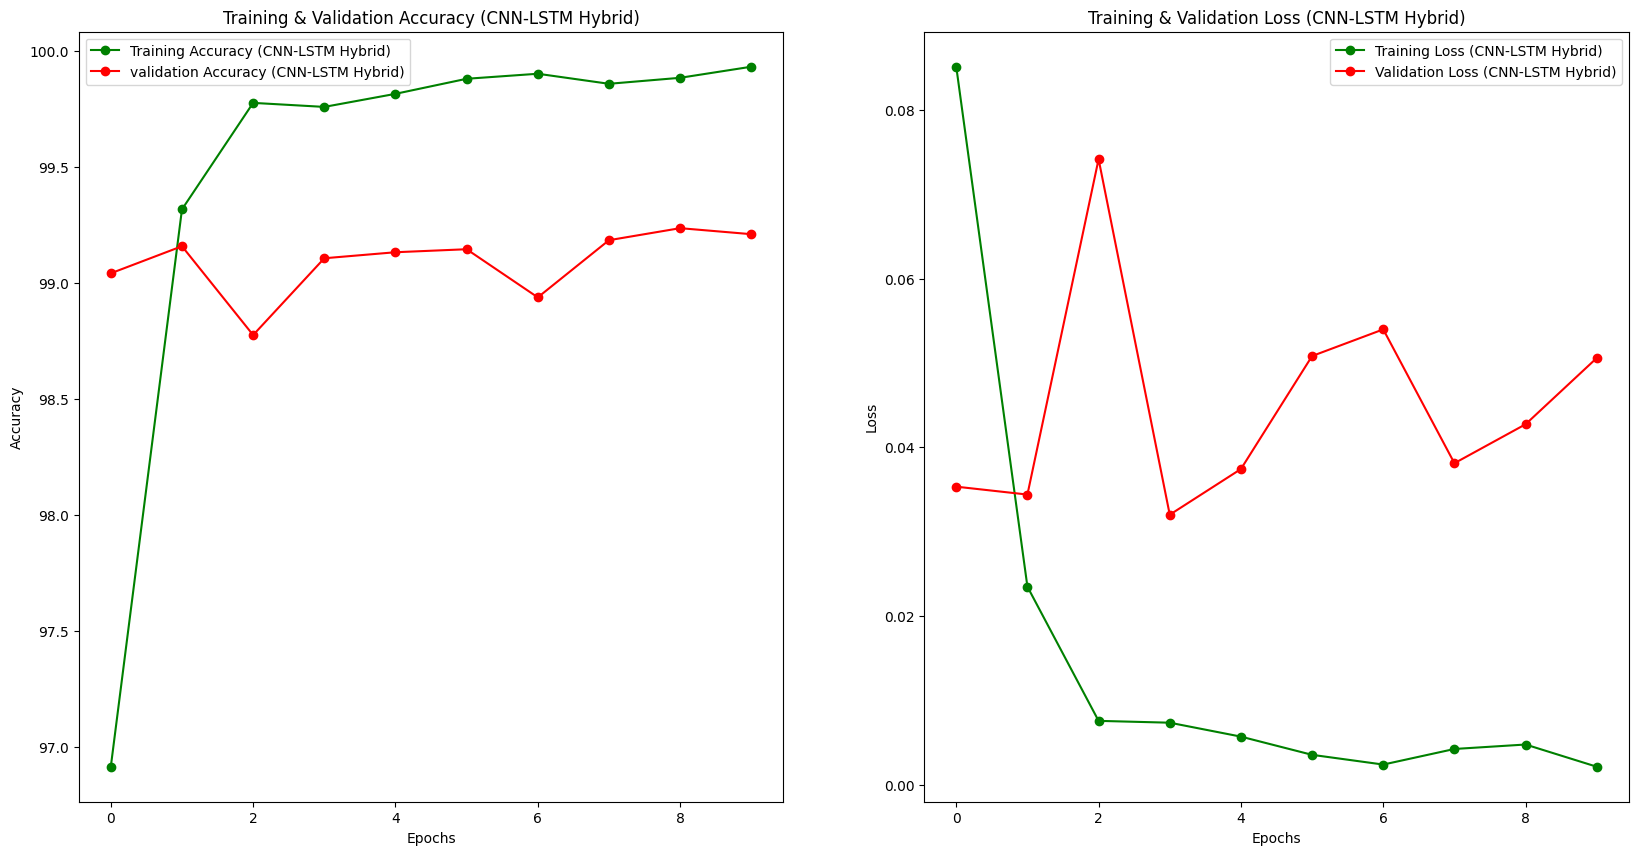

In [77]:
epochs = [i for i in range(numEpochs)]
fig , ax = plt.subplots(1,2)
fig.set_size_inches(20,10)

ax[0].plot(epochs , train_accs_hybrid , 'go-' , label = 'Training Accuracy (CNN-LSTM Hybrid)')
ax[0].plot(epochs , valid_accs_hybrid , 'ro-' , label = 'validation Accuracy (CNN-LSTM Hybrid)')
ax[0].set_title('Training & Validation Accuracy (CNN-LSTM Hybrid)')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs , train_losses_hybrid , 'go-' , label = 'Training Loss (CNN-LSTM Hybrid)')
ax[1].plot(epochs , valid_losses_hybrid , 'ro-' , label = 'Validation Loss (CNN-LSTM Hybrid)')
ax[1].set_title('Training & Validation Loss (CNN-LSTM Hybrid)')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Loss")
plt.show()

# 11. Save & Load Models

In [78]:
def saveCheckpoint(
    model,
    optimizer,
    epoch,
    name,
    train_losses,
    valid_losses,
    test_loss,
    train_accs,
    valid_accs,
    test_acc,
    test_preds,
):
    checkpoint = {
        "epoch": epoch,
        "model_state_dict": model.state_dict(),
        "optimizer_state_dict": optimizer.state_dict(),
        "train_losses": train_losses,
        "valid_losses": valid_losses,
        "test_loss": test_loss,
        "train_accs": train_accs,
        "valid_accs": valid_accs,
        "test_acc": test_acc,
        "test_preds": test_preds,
    }
    
    path = name + "_checkpoint.pth"
    torch.save(checkpoint, path)
    print(f"Checkpoint saved at epoch {epoch} to {path}")

In [79]:
saveCheckpoint(
    model_lstm,
    optimizer_lstm,
    numEpochs,
    "Model_LSTM",
    train_losses_lstm,
    valid_losses_lstm,
    test_loss_lstm,
    train_accs_lstm,
    valid_accs_lstm,
    test_acc_lstm,
    test_preds_lstm,
)

saveCheckpoint(
    model_cnn,
    optimizer_cnn,
    numEpochs,
    "Model_CNN",
    train_losses_cnn,
    valid_losses_cnn,
    test_loss_cnn,
    train_accs_cnn,
    valid_accs_cnn,
    test_acc_cnn,
    test_preds_cnn,
)

saveCheckpoint(
    model_hybrid,
    optimizer_hybrid,
    numEpochs,
    "Model_Hybrid",
    train_losses_hybrid,
    valid_losses_hybrid,
    test_loss_hybrid,
    train_accs_hybrid,
    valid_accs_hybrid,
    test_acc_hybrid,
    test_preds_hybrid,
)

Checkpoint saved at epoch 10 to Model_LSTM_checkpoint.pth
Checkpoint saved at epoch 10 to Model_CNN_checkpoint.pth
Checkpoint saved at epoch 10 to Model_Hybrid_checkpoint.pth


In [80]:
(
    model_lstm,
    optimizer_lstm,
    epoch_lstm,
    train_losses_lstm,
    valid_losses_lstm,
    test_loss_lstm,
    train_accs_lstm,
    valid_accs_lstm,
    test_acc_lstm,
    test_preds_lstm,
) = loadCheckpoint(model_lstm, optimizer_lstm, "Model_LSTM_checkpoint.pth")

(
    model_cnn,
    optimizer_cnn,
    epoch_cnn,
    train_losses_cnn,
    valid_losses_cnn,
    test_loss_cnn,
    train_accs_cnn,
    valid_accs_cnn,
    test_acc_cnn,
    test_preds_cnn,
) = loadCheckpoint(model_cnn, optimizer_cnn, "Model_CNN_checkpoint.pth")

(
    model_hybrid,
    optimizer_hybrid,
    epoch_hybrid,
    train_losses_hybrid,
    valid_losses_hybrid,
    test_loss_hybrid,
    train_accs_hybrid,
    valid_accs_hybrid,
    test_acc_hybrid,
    test_preds_hybrid,
) = loadCheckpoint(model_hybrid, optimizer_hybrid, "Model_Hybrid_checkpoint.pth")

Checkpoint loaded from Model_LSTM_checkpoint.pth, epoch 10
Checkpoint loaded from Model_CNN_checkpoint.pth, epoch 10
Checkpoint loaded from Model_Hybrid_checkpoint.pth, epoch 10


# 12. Statistics

#### Test Predictions

In [81]:
preds = [
    (torch.sigmoid(t) > 0.5).int().tolist() if isinstance(t, torch.Tensor) else [int(t > 0.5)]
    for t in test_preds_hybrid
]

preds = [item for sublist in preds for item in sublist]


In [82]:
preds[:20]

[0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1]

In [83]:
test_y[:20]

19472    0
2051     1
34636    0
7123     1
38050    0
31334    1
6430     1
9828     1
16417    1
3716     1
14430    0
13967    1
37385    1
3804     1
28593    0
29827    1
34968    1
31447    0
16847    0
22182    1
Name: True, dtype: int64

#### Confusion Matrix & Normalization

In [84]:
cm = confusion_matrix(preds,test_y)

Text(45.722222222222214, 0.5, 'Actual')

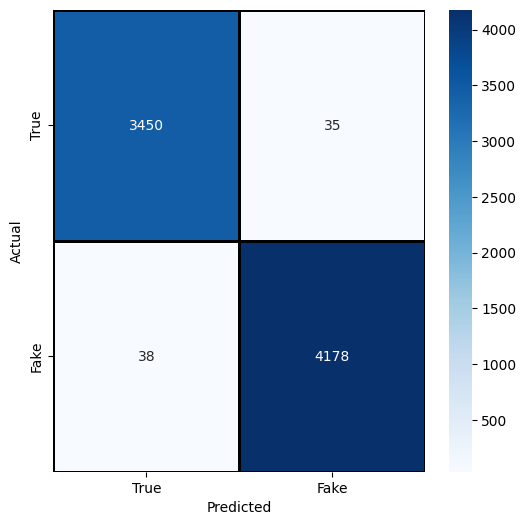

In [85]:
plt.figure(figsize = (6,6))
sns.heatmap(cm,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='' , xticklabels = ['True','Fake'] , yticklabels = ['True','Fake'])
plt.xlabel("Predicted")
plt.ylabel("Actual")

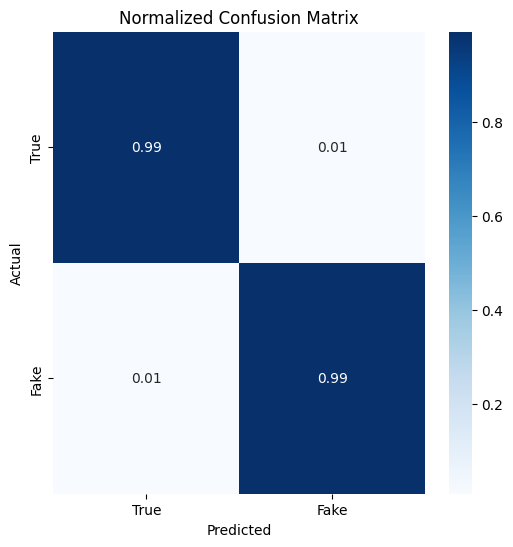

In [86]:
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(6,6))
sns.heatmap(cm_normalized, annot=True, fmt=".2f", cmap="Blues", xticklabels=['True', 'Fake'], yticklabels=['True', 'Fake'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Normalized Confusion Matrix")
plt.show()

#### Error Analysis

In [87]:
compare =  pd.DataFrame({'Ground truth' : test_y, 'Predicted': preds})
index_fn = np.nonzero(compare['Ground truth'] - compare['Predicted'] == 1) 
index_fp = np.nonzero(compare['Ground truth'] - compare['Predicted'] == -1)

In [88]:
print(f"False Negatives: {index_fn[0][0]}")

False Negatives: 72


In [89]:
print(f"False Positives: {index_fp[0][0]}")

False Positives: 101


#### Accuracy, Precision, Recall, F1-Score (for each class)

In [90]:
test_y_numpy = np.array(test_y)
preds_numpy = np.array(preds)

accuracy = accuracy_score(test_y_numpy, preds_numpy)
accuracy_true = accuracy_score(test_y_numpy[test_y_numpy == 1], preds_numpy[test_y_numpy == 1])
accuracy_fake = accuracy_score(test_y_numpy[test_y_numpy == 0], preds_numpy[test_y_numpy == 0])

print(f"Accuracy for True class: {accuracy_true:.4f}")
print(f"Accuracy for Fake class: {accuracy_fake:.4f}")
precision_true = precision_score(test_y_numpy, preds_numpy, pos_label=1)
precision_fake = precision_score(test_y_numpy, preds_numpy, pos_label=0)
recall_true = recall_score(test_y_numpy, preds_numpy, pos_label=1)
recall_fake = recall_score(test_y_numpy, preds_numpy, pos_label=0)
f1_true = f1_score(test_y_numpy, preds_numpy, pos_label=1)
f1_fake = f1_score(test_y_numpy, preds_numpy, pos_label=0)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision (True): {precision_true:.4f}")
print(f"Precision (Fake): {precision_fake:.4f}")
print(f"Recall (True): {recall_true:.4f}")
print(f"Recall (Fake): {recall_fake:.4f}")
print(f"F1 Score (True): {f1_true:.4f}")
print(f"F1 Score (Fake): {f1_fake:.4f}")

Accuracy for True class: 0.9917
Accuracy for Fake class: 0.9891
Accuracy: 0.9905
Precision (True): 0.9910
Precision (Fake): 0.9900
Recall (True): 0.9917
Recall (Fake): 0.9891
F1 Score (True): 0.9913
F1 Score (Fake): 0.9895


In [91]:
print(classification_report(test_y, preds, target_names = ['Predicted Fake','Predicted True']))

                precision    recall  f1-score   support

Predicted Fake       0.99      0.99      0.99      3488
Predicted True       0.99      0.99      0.99      4213

      accuracy                           0.99      7701
     macro avg       0.99      0.99      0.99      7701
  weighted avg       0.99      0.99      0.99      7701



#### Precision-Recall Curve

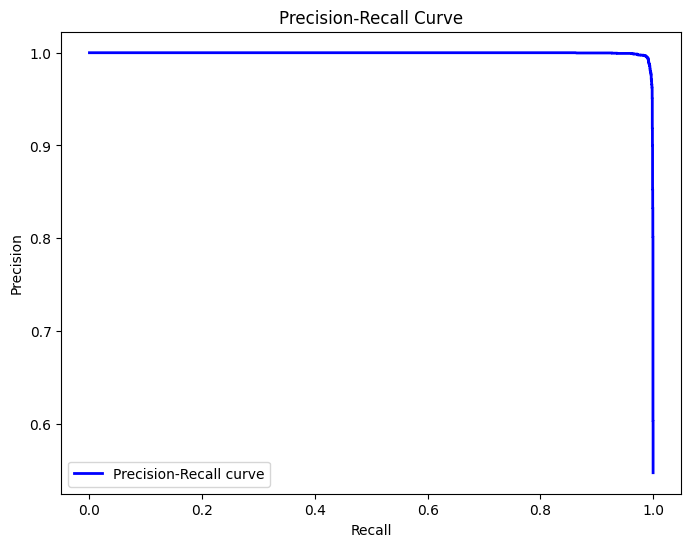

In [92]:
if isinstance(test_preds_hybrid, list):
    test_preds_hybrid_tensor = torch.cat([torch.tensor(t) if isinstance(t, torch.Tensor) else torch.tensor([t]) for t in test_preds_hybrid])
else:
    test_preds_hybrid_tensor = torch.tensor(test_preds_hybrid)
    
predictions = torch.sigmoid(test_preds_hybrid_tensor).cpu().detach().numpy()
precision, recall, _ = precision_recall_curve(test_y_numpy, predictions)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='blue', lw=2, label='Precision-Recall curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")
plt.show()

#### ROC Curve and AUC

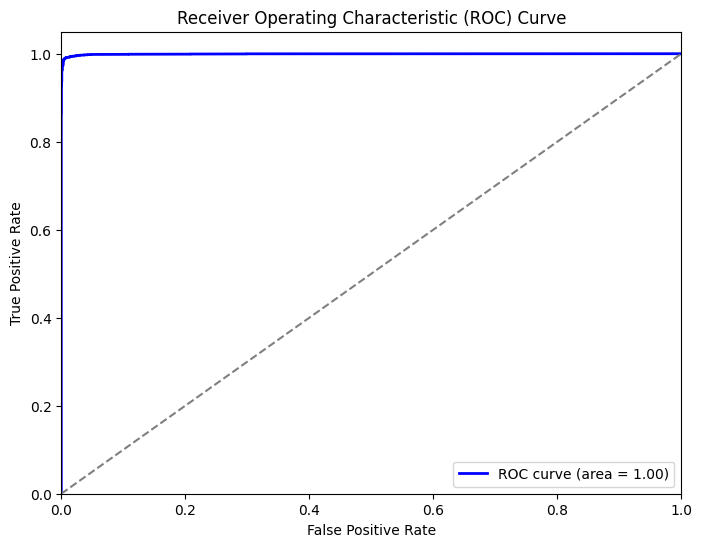

In [93]:
fpr, tpr, thresholds = roc_curve(test_y, [torch.sigmoid(t).item() for t in test_preds_hybrid_tensor])
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

#### Classification Accuracy per Class

In [94]:
# True class (1 = True, 0 = Fake)
accuracy_true = accuracy_score(test_y_numpy[test_y_numpy == 1], preds_numpy[test_y_numpy == 1])
accuracy_fake = accuracy_score(test_y_numpy[test_y_numpy == 0], preds_numpy[test_y_numpy == 0])

print(f"Accuracy for True class: {accuracy_true:.4f}")
print(f"Accuracy for Fake class: {accuracy_fake:.4f}")


Accuracy for True class: 0.9917
Accuracy for Fake class: 0.9891


#### Learning Curves (Training vs Validation Loss)

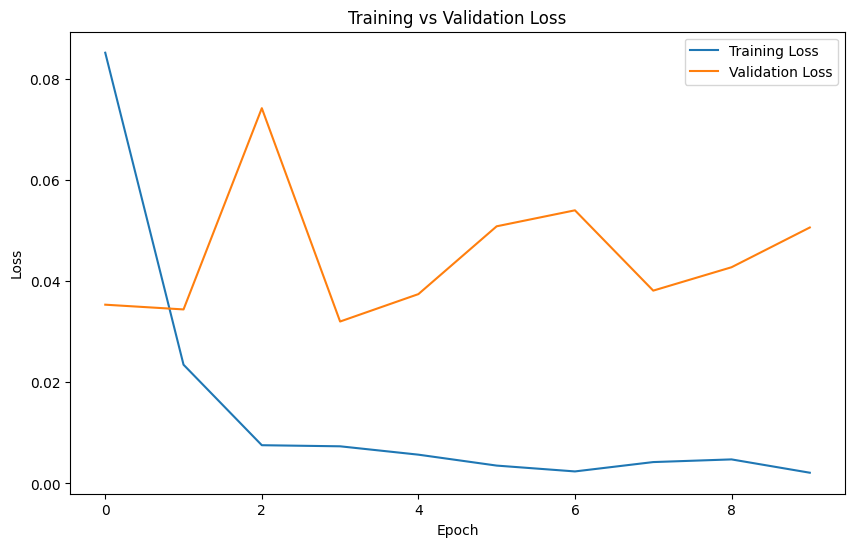

In [95]:
plt.figure(figsize=(10, 6))
plt.plot(train_losses_hybrid, label='Training Loss')
plt.plot(valid_losses_hybrid, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.show()

# 13. Grid Search for Hyperparameter Tuning

In [96]:
learning_rates = [0.005, 0.01]
batch_sizes = [32, 64]
hidden_dims = [128, 256, 512]
filter_multipliers = [64, 128, 256]

param_grid = list(itertools.product(
    learning_rates,
    batch_sizes,
    hidden_dims,
    filter_multipliers
))

In [97]:
def createNewDL(paddedData, labels, batch_size, shuffle=False):
    dataset = list(zip(paddedData, labels))
    return DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)

In [98]:
def gridSearch(model_class, param_grid, train_data, valid_data, test_data, device):
    best_valid_acc = 0
    best_params = None
    best_model = None

    for params in param_grid:
        learning_rate, batch_size, hidden_dim, filter_multiplier = params
        
        # Create the DataLoaders with current batch size using raw data (train_data, valid_data, test_data)
        trainPadded, trainLabels = train_data
        validPadded, validLabels = valid_data
        testPadded, testLabels = test_data
        
        # Create DataLoaders
        trainDL = createNewDL(trainPadded, trainLabels, batch_size, shuffle=True)
        validDL = createNewDL(validPadded, validLabels, batch_size, shuffle=False)
        testDL = createNewDL(testPadded, testLabels, batch_size, shuffle=False)

        # Initialize the model, optimizer, and criterion with current hyperparameters
        model = model_class(300, VOCAB_SIZE, hidden_dim, filter_multiplier=filter_multiplier)
        optimizer = Adam(model.parameters(), lr=learning_rate, betas=(0.9, 0.999), weight_decay=1e-5)
        criterion = nn.BCEWithLogitsLoss()

        # Train the model
        print(f"Training with: lr={learning_rate}, batch_size={batch_size}, hidden_dim={hidden_dim} filter_multiplier={filter_multiplier}")
        train_losses, valid_losses, test_loss, train_accs, valid_accs, test_acc, test_preds = experiment(
            model, optimizer, criterion, trainDL, validDL, testDL, numEpochs=5, device=device
        )
        
        valid_acc = valid_accs[-1]

        # Check if this model is better
        if valid_acc > best_valid_acc:
            best_valid_acc = valid_acc
            best_params = params
            best_model = model
            print(f"New best model found with validation accuracy: {valid_acc:.4f}")

    print(f"\nBest Validation Accuracy: {best_valid_acc:.4f}")
    print(f"Best Hyperparameters: {best_params}")
    
    # Return best model and its performance on test set
    test_loss, test_acc, test_preds = eval_model(best_model, criterion, testDL, device)
    print(f"Test Accuracy for Best Model: {test_acc:.4f}")
    print(f"Test Loss for Best Model: {test_loss:.4f}")
    return best_model, best_params

In [99]:
# best_model, best_params = gridSearch(
#     Hybrid, param_grid, (trainPadded, trainLabels), (validPadded, validLabels), (testPadded, testLabels), device
# )

# test_preds_flat = [t.item() for t in best_model(test_preds_hybrid)]
# test_preds_tensor = torch.tensor(test_preds_flat)
# predictions = torch.sigmoid(test_preds_tensor).cpu().detach().numpy()
# print(classification_report(test_y, predictions))